## Clustering Youtube Thumbnails

sources: https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

In [301]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

import json
from PIL import Image



### Loading Data

In [17]:
path = '/Users/vidya/MRDVGroupProjectCSPB4502/src/Vidya/images'
os.chdir(path)

# this list holds all the image filename
thumbnail_filenames = []

# creates a ScandirIterator aliased as files
with os.scandir(path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the thumbnail_filenames list
            thumbnail_filenames.append(file.name)

### function to preprocess images and use VGG Model to extract features

In [18]:
# load the model first and pass as an argument
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

553476096/553467096 [==============================] - 100s 0us/step


### run model on images

In [19]:
data = {}
p = r'/Users/vidya/MRDVGroupProjectCSPB4502/src/Vidya/model/features.pkl'

# loop through each image in the dataset
for i in thumbnail_filenames:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(i,model)
        data[i] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

In [148]:
# outputs feature analysis so can use without all the earlier steps :)

p2 = r'/Users/vidya/MRDVGroupProjectCSPB4502/src/Vidya/model/data_processed.pkl'

filehandler = open(p2, 'wb')
pickle.dump(data, filehandler)

In [23]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [24]:
# get a list of just the features
feat = np.array(list(data.values()))
feat.shape

(945, 1, 4096)

In [25]:
# reshape so that there are 945 samples of 4096 vectors
feat = feat.reshape(-1,4096)
feat.shape

(945, 4096)

In [375]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

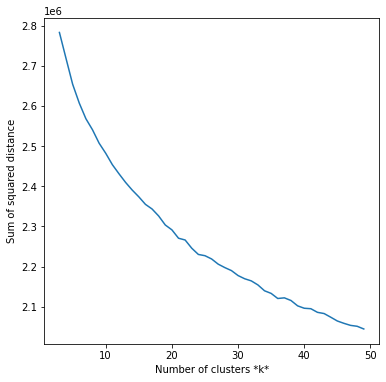

In [387]:
# to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(x)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

In [348]:
# approximately based on graph of sse against k

kmeans = KMeans(n_clusters=20,random_state=22)
kmeans.fit(x)
kmeans.labels_

array([ 6,  8,  2, 18,  4, 18,  4,  7,  4, 14, 19,  9, 12, 16, 11,  4,  1,
        6, 11, 15, 19,  1,  6, 13, 16,  2,  4,  7,  3,  0,  9,  4,  6,  6,
       19,  9,  8, 12, 14,  6,  6, 13,  6,  7, 16,  0, 18,  8,  9, 17,  1,
        5, 14,  7, 14, 16,  1,  6, 13, 16,  9,  2, 16,  4,  5,  9,  7,  4,
       17,  0,  7, 14, 19,  1,  5,  5, 13, 19,  4, 11,  0, 14,  9,  3, 13,
       17, 16,  5, 17, 15,  5,  2, 14,  2,  7,  6, 17, 16,  6, 11,  4,  9,
        6, 13, 14,  2, 11, 14,  5,  5, 14,  7,  5,  4,  4, 19,  3, 11, 18,
        0,  5,  2,  9,  5,  6, 11,  6, 11, 12, 19, 16,  7,  8,  1, 14, 15,
        6,  2,  1, 12, 19,  6,  7,  6,  6,  0,  7,  8,  8, 11,  7,  3,  1,
        9,  4, 17,  5,  4, 15,  7,  4,  5, 19,  3,  1, 13,  6,  6, 18,  4,
       18,  2,  7,  5, 19,  1,  9,  7,  8, 19, 18,  2,  3, 15,  4, 18, 19,
        0, 10,  6,  6, 19,  9, 12,  4,  0,  6,  3,  2,  5,  2,  1, 16,  6,
       15,  4,  0,  6, 15,  8, 15, 12, 14,  6,  1, 19, 19,  9, 10, 13,  2,
        2, 12,  7,  5, 14

In [349]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [350]:
for key in groups:
    print(str(key)+': '+str(len(groups[key])))

6: 77
8: 50
2: 61
18: 36
4: 69
7: 93
14: 59
19: 72
9: 55
12: 43
16: 33
11: 34
1: 32
15: 38
13: 27
3: 23
0: 38
17: 40
5: 60
10: 5


In [352]:
# export clustered groups!

p3 = r'/Users/vidya/MRDVGroupProjectCSPB4502/src/Vidya/model/clustered_groups.pkl'

filehandler = open(p3, 'wb')
pickle.dump(groups, filehandler)

In [353]:
try:
    test = open('../model/test.txt', 'wt')
    test.write(str(groups))
    test.close()
  
except:
    print("Unable to write to file")

## Image t-SNE for Thumbnails

source: https://github.com/ml4a/ml4a/blob/master/examples/info_retrieval/image-tsne.ipynb

In [354]:
X = np.array(x)

In [355]:
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 945 samples in 0.005s...
[t-SNE] Computed neighbors for 945 samples in 0.180s...
[t-SNE] Computed conditional probabilities for sample 945 / 945
[t-SNE] Mean sigma: 16.133336
[t-SNE] Computed conditional probabilities in 0.062s
[t-SNE] Iteration 50: error = 73.1537170, gradient norm = 0.3374566 (50 iterations in 1.298s)
[t-SNE] Iteration 100: error = 74.9070435, gradient norm = 0.3088554 (50 iterations in 1.151s)
[t-SNE] Iteration 150: error = 75.0673981, gradient norm = 0.3160732 (50 iterations in 1.100s)
[t-SNE] Iteration 200: error = 74.7431641, gradient norm = 0.3222896 (50 iterations in 1.411s)
[t-SNE] Iteration 250: error = 76.2686768, gradient norm = 0.2682462 (50 iterations in 1.457s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.268677
[t-SNE] Iteration 300: error = 2.0483253, gradient norm = 0.0031362 (50 iterations in 1.031s)
[t-SNE] Iteration 350: error = 1.8988845, gradient norm = 0.0010934 

In [356]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

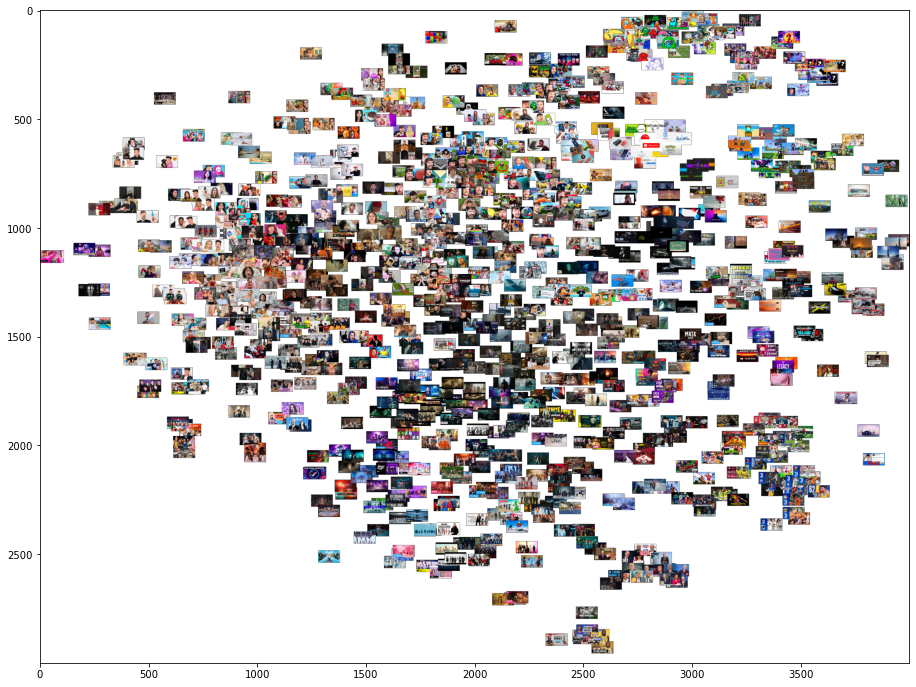

In [357]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(filenames, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

plt.figure(figsize = (16,12))
plt.imshow(full_image)

In [358]:
full_image.save("image-plot.png")

In [359]:
tsne_path = "image-tsne-results.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(filenames, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)


saved t-SNE result to image-tsne-results.json


In [360]:
import rasterfairy

# nx * ny = 945, the number of images
nx = 35
ny = 27

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

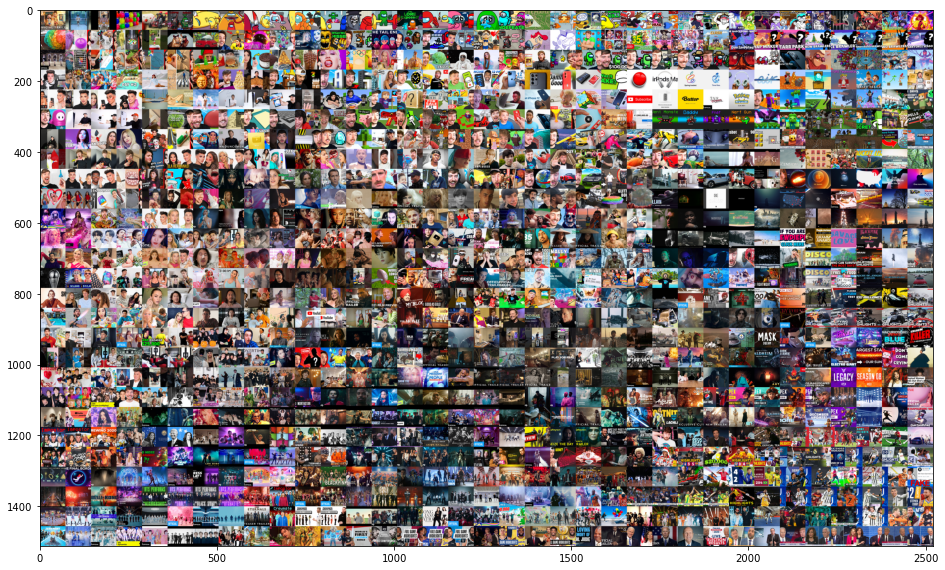

In [361]:
tile_width = 72
tile_height = 56

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(filenames, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

plt.figure(figsize = (16,12))
plt.imshow(grid_image)

In [362]:
grid_image.save("grid-image.jpg")

In [363]:
p4 = r'/Users/vidya/MRDVGroupProjectCSPB4502/src/Vidya/model/clustered_groups.pkl'

filehandler = open(p4, 'wb')
pickle.dump(groups, filehandler)

In [364]:
try:
    test = open('../model/test.txt', 'wt')
    test.write(str(groups))
    test.close()
  
except:
    print("Unable to write to file")

## Some Interesting Clusters

In [365]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 100 images to be shown at a time
    if len(files) > 100:
        print(f"Clipping cluster size from {len(files)} to 100")
        files = files[:100]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off') 

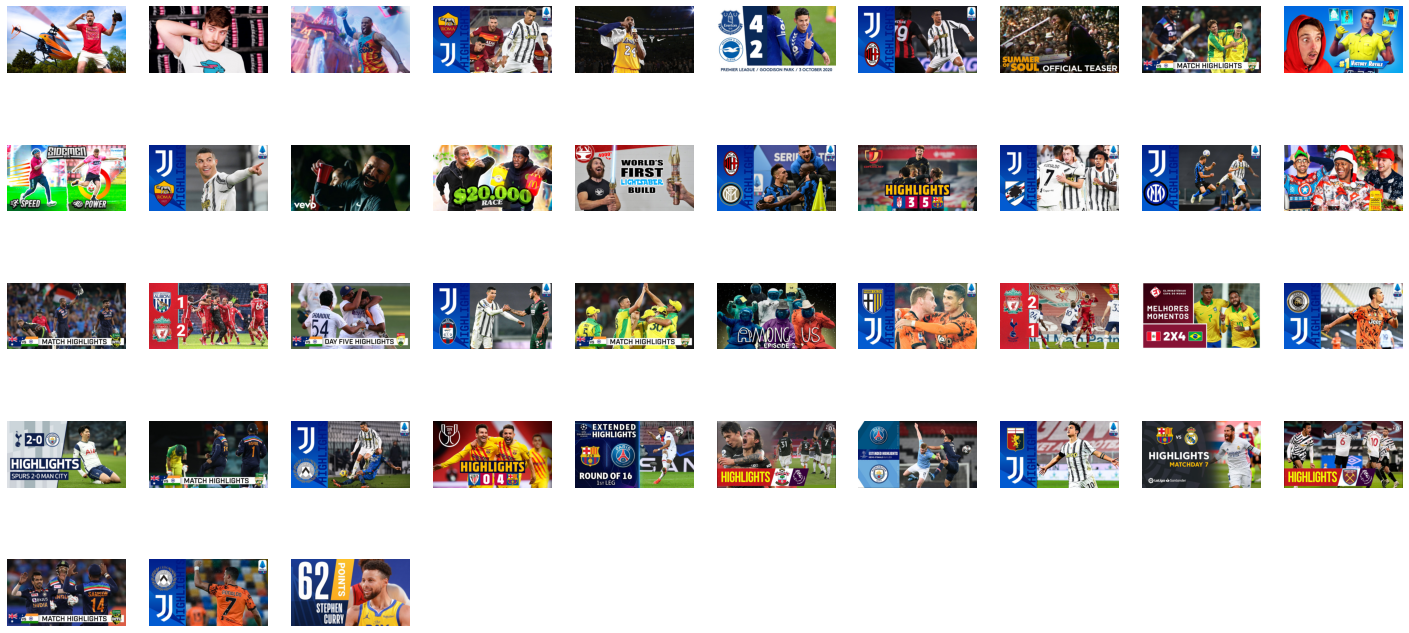

In [366]:
view_cluster(12)

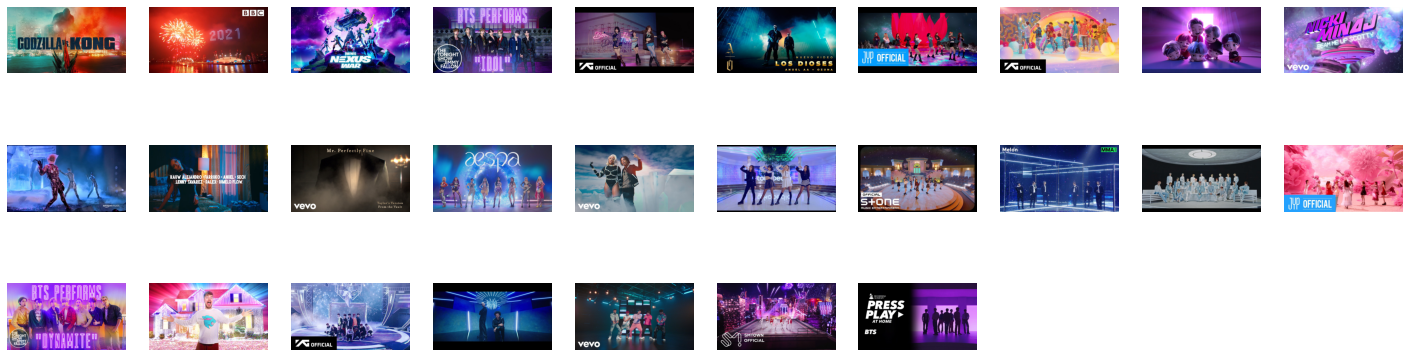

In [367]:
view_cluster(13)

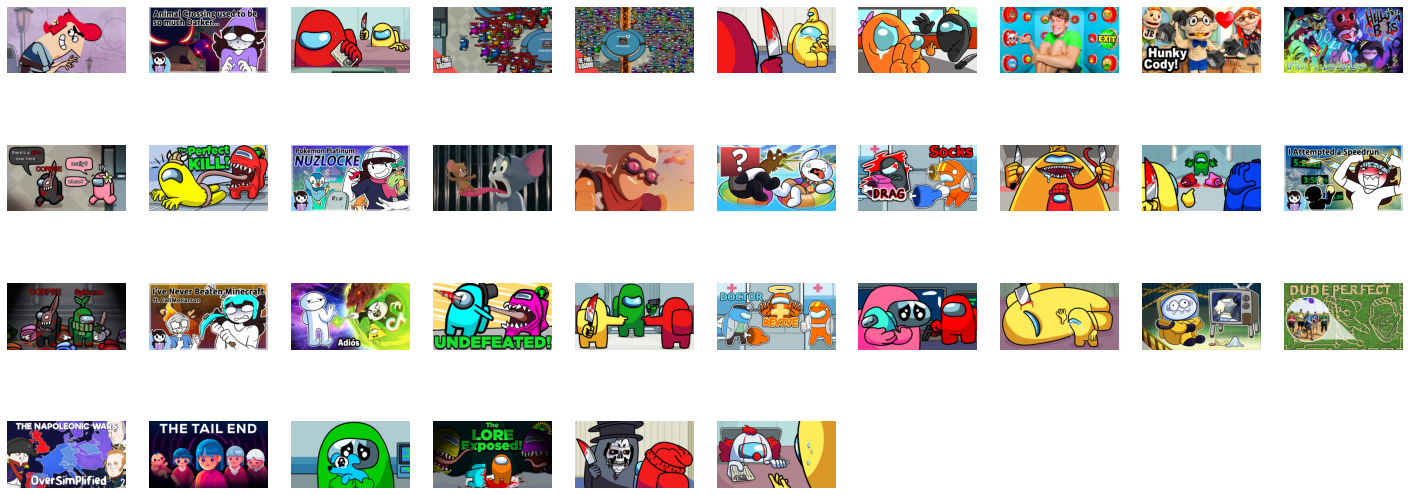

In [368]:
view_cluster(18)